In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import os
import ast
import torch
import pickle
import keyboard
import numpy as np
import pandas as pd
from utils.env_utils import *
from utils.eval_utils import *
import matplotlib.pyplot as plt
from utils.train_utils import *
from utils.couzin_utils import *
from marl_aquarium import aquarium_v0
from models.Buffer import Pool, Buffer
from sklearn.preprocessing import MinMaxScaler

## Model Comparison using Swarm Metrics

In [2]:
gail_folder = "GAIL Training - 19.11.2025_18.52 - Couzin Data"
bc_folder = "BC Training - 19.11.2025_18.52 - Couzin Data"

model_folder = rf"..\data\2. Training\training"
gail_path = os.path.join(model_folder, "GAIL", gail_folder)
bc_path = os.path.join(model_folder, "BC", bc_folder)

expert_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected\expert_metrics_yd.pkl'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
start_frame_pool = Pool(max_length=12100, device=device)
start_frame_pool.generate_startframes(ftw_path)

env = parallel_env(predator_count=1, prey_count=32, action_count=360, use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
print("Environment initialized")

Environment initialized


In [5]:
num_steps = 100

# GAIL Simulation
gail_pred_policy = torch.load(os.path.join(gail_path, "bc_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(gail_path, "bc_prey_policy.pt"), weights_only=False)
gail_metrics = run_policies_in_steps(env, gail_pred_policy, gail_prey_policy, steps=num_steps, render=False)
print("GAIL Simulation done!")

# BC Simulation
bc_pred_policy = torch.load(os.path.join(bc_path, "bc_pred_policy.pt"), weights_only=False)
bc_prey_policy = torch.load(os.path.join(bc_path, "bc_prey_policy.pt"), weights_only=False)
bc_metrics = run_policies_in_steps(env, bc_pred_policy, bc_prey_policy, steps=num_steps, render=False)
print("BC Simulation done!")

# Couzin Simulation
pred_tensor, prey_tensor, pred_log, prey_log = run_couzin_simulation(visualization="off", max_steps=num_steps)
print("Couzin Simulation done!")

# Load Expert Data
with open(expert_path, "rb") as f:
    expert_data = pickle.load(f)
expert_metrics = compute_expert_metrics(expert_data, 33)

GAIL Simulation done!
BC Simulation done!
Couzin Simulation done!


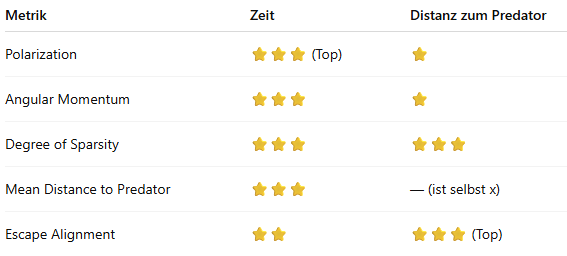

In [8]:
def plot_swarm_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics):
    df_gail = pd.DataFrame(gail_metrics)
    df_bc = pd.DataFrame(bc_metrics)
    df_couzin = pd.DataFrame(couzin_metrics)
    steps = np.arange(len(df_gail))

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    ### POLARIZATION ###
    gail_polarization = list(df_gail["polarization"])
    bc_polarization = list(df_bc["polarization"])
    couzin_polarization = list(df_couzin["polarization"])
    expert_polarization = np.mean(expert_metrics["polarization"])

    axes[0].plot(steps, gail_polarization, label="GAIL", color="#005555", linewidth=1)
    axes[0].plot(steps, bc_polarization, label="BC", color="#777777", linewidth=1)
    axes[0].plot(steps, couzin_polarization, label="Couzin", color="#a7a7a8", linewidth=1)
    axes[0].axhline(expert_polarization, label="Expert", color="#000000", linewidth=1)

    axes[0].set_xlabel("Steps", fontsize=14)
    axes[0].set_ylabel("Polarization", fontsize=14)
    axes[0].set_title("Polarization Over Time", fontsize=18)
    axes[0].set_ylim(0, 1)
    axes[0].legend()

    ### ANGULAR MOMENTUM ###
    gail_am = list(df_gail["angular_momentum"])
    bc_am = list(df_bc["angular_momentum"])
    couzin_am = list(df_couzin["angular_momentum"])
    expert_am = np.mean(expert_metrics["angular_momentum"])
    min_am = min(min(gail_am), min(bc_am), min(couzin_am), expert_am)
    max_am = max(max(gail_am), max(bc_am), max(couzin_am), expert_am)

    axes[1].plot(steps, gail_am, label="GAIL", color="#005555", linewidth=1)
    axes[1].plot(steps, bc_am, label="BC", color="#777777", linewidth=1)
    axes[1].plot(steps, couzin_am, label="Couzin", color="#a7a7a8", linewidth=1)
    axes[1].axhline(expert_am, label="Expert", color="#000000", linewidth=1)

    axes[1].set_xlabel("Steps", fontsize=14)
    axes[1].set_ylabel("Angular Momentum", fontsize=14)
    axes[1].set_title("Angular Momentum Over Time", fontsize=18)
    axes[1].set_ylim(0, max_am)
    axes[1].legend()

    ### DEGREE OF SPARSITY ###
    gail_dos = list(df_gail["degree_of_sparsity"])
    bc_dos = list(df_bc["degree_of_sparsity"])
    couzin_dos = list(df_couzin["degree_of_sparsity"])
    expert_dos = np.mean(expert_metrics["sparsity"])
    min_dos = min(min(gail_dos), min(bc_dos), min(couzin_dos))
    max_dos = max(max(gail_dos), max(bc_dos), max(couzin_dos))

    axes[2].plot(steps, gail_dos, label="GAIL", color="#005555", linewidth=1)
    axes[2].plot(steps, bc_dos, label="BC", color="#777777", linewidth=1)
    axes[2].plot(steps, couzin_dos, label="Couzin", color="#a7a7a8", linewidth=1)
    axes[2].axhline(expert_dos, label="Expert", color="#000000", linewidth=1)

    axes[2].set_xlabel("Steps", fontsize=14)
    axes[2].set_ylabel("Degree of Sparsity", fontsize=14)
    axes[2].set_title("Degree of Sparsity Over Time", fontsize=18)
    axes[2].set_ylim(0, max_dos)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

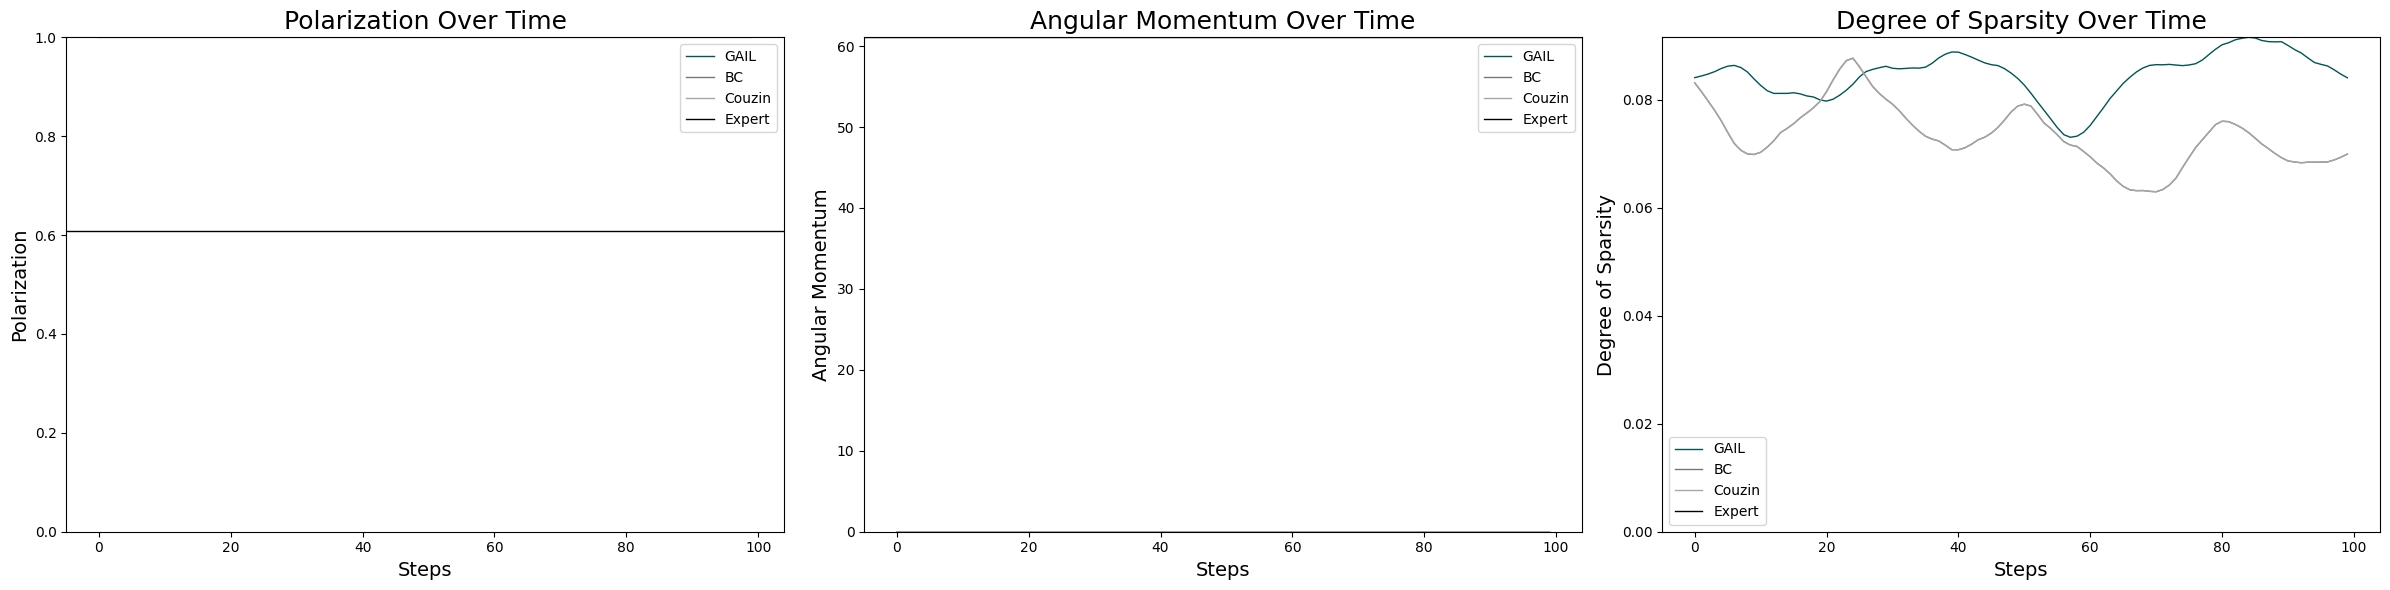

In [9]:
plot_swarm_metrics(gail_metrics, bc_metrics, bc_metrics, expert_metrics)

In [10]:
def plot_pred_prey_metrics(gail_metrics, bc_metrics, couzin_metrics, expert_metrics):
    df_gail = pd.DataFrame(gail_metrics)
    df_bc = pd.DataFrame(bc_metrics)
    df_couzin = pd.DataFrame(couzin_metrics)
    steps = np.arange(len(df_gail))

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ### DISTANCE TO PREDATOR ###
    gail_dtp = list(df_gail["distance_to_predator"])
    bc_dtp = list(df_bc["distance_to_predator"])
    couzin_dtp = list(df_couzin["distance_to_predator"])
    expert_dtp = np.mean(expert_metrics["distance_to_predator"])

    min_dtp = min(min(gail_dtp), min(bc_dtp), min(couzin_dtp), expert_dtp)
    max_dtp = max(max(gail_dtp), max(bc_dtp), max(couzin_dtp), expert_dtp)

    axes[0].plot(steps, gail_dtp, label="GAIL", color="#005555", linewidth=1)
    axes[0].plot(steps, bc_dtp,   label="BC", color="#777777", linewidth=1)
    axes[0].plot(steps, couzin_dtp, label="Couzin", color="#a7a7a8", linewidth=1)
    axes[0].axhline(expert_dtp, label="Expert", color="#000000", linewidth=1)

    axes[0].set_xlabel("Steps", fontsize=14)
    axes[0].set_ylabel("Distance to Predator", fontsize=14)
    axes[0].set_title("Distance to Predator Over Time", fontsize=18)
    axes[0].set_ylim(-10, 2000)
    axes[0].legend()

    ### ESCAPE ALIGNMENT ###
    gail_ea = list(df_gail["escape_alignment"])
    bc_ea = list(df_bc["escape_alignment"])
    couzin_ea = list(df_couzin["escape_alignment"])
    expert_ea = np.mean(expert_metrics["escape_alignment"])

    axes[1].plot(steps, gail_ea, label="GAIL", color="#005555", linewidth=1)
    axes[1].plot(steps, bc_ea,   label="BC", color="#777777", linewidth=1)
    axes[1].plot(steps, couzin_ea, label="Couzin", color="#a7a7a8", linewidth=1)
    axes[1].axhline(expert_ea, label="Expert", color="#000000", linewidth=1)

    axes[1].set_xlabel("Steps", fontsize=14)
    axes[1].set_ylabel("Escape Alignment", fontsize=14)
    axes[1].set_title("Escape Alignment Over Time", fontsize=18)
    axes[1].set_ylim(-1, 1) # positive alignment away from predator
    axes[1].legend()

    plt.tight_layout()
    plt.show()


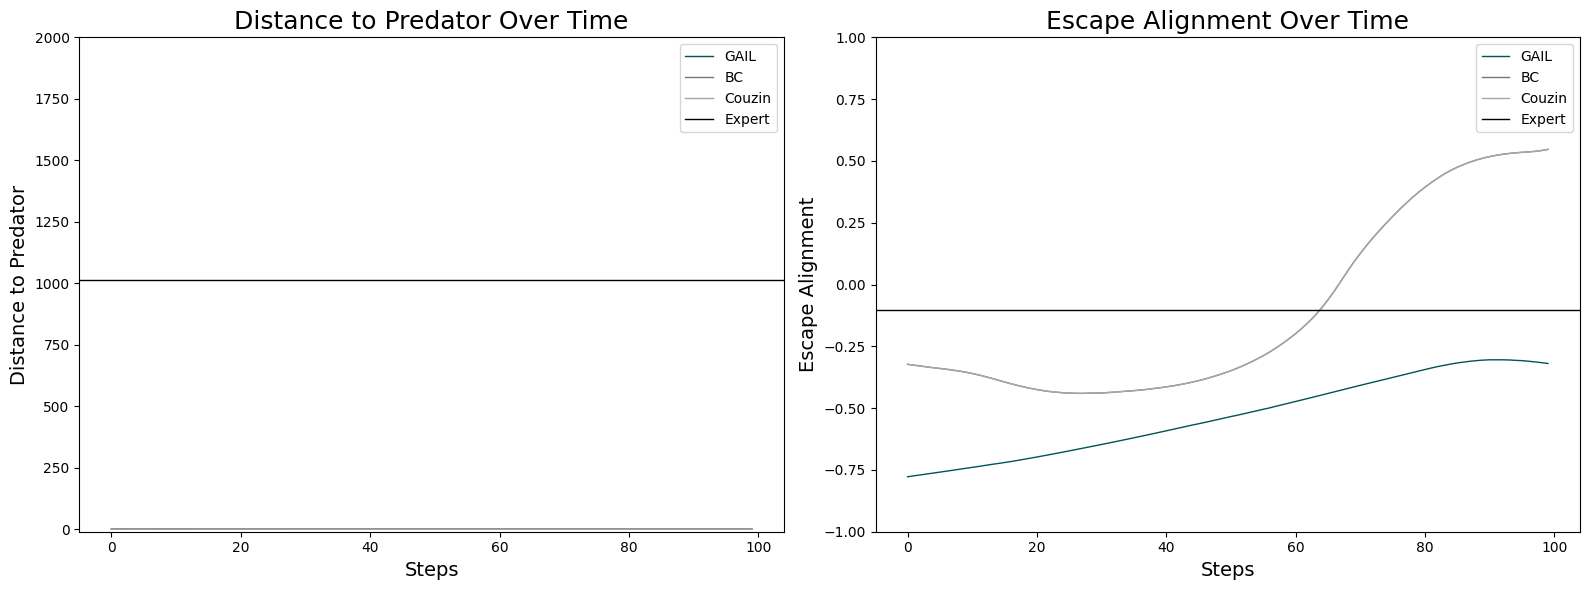

In [11]:
plot_pred_prey_metrics(gail_metrics, bc_metrics, bc_metrics, expert_metrics)

In [ ]:
df_gail = pd.DataFrame(gail_metrics)
df_bc = pd.DataFrame(bc_metrics)


gail_dtp = list(df_gail["distance_to_predator"])
bc_dtp = list(df_bc["distance_to_predator"])
expert_dtp = float(expert_metrics["distance_to_predator"])

print("GAIL Distance to Predator:", gail_dtp)
print("BC Distance to Predator:", np.mean(bc_dtp))
print("Expert Distance to Predator:", expert_dtp)

GAIL Distance to Predator: [0.7746936082839966, 0.7750878930091858, 0.7758835554122925, 0.7771113514900208, 0.778099000453949, 0.7788785696029663, 0.7794933915138245, 0.7800894975662231, 0.7809338569641113, 0.7820947766304016, 0.7836061716079712, 0.7855039238929749, 0.7878091335296631, 0.790560245513916, 0.7937912940979004, 0.7975144386291504, 0.8017374873161316, 0.806466281414032, 0.8117018938064575, 0.8174294233322144, 0.8236430883407593, 0.8303347229957581, 0.8375000357627869, 0.8451129794120789, 0.8531501293182373, 0.8615949749946594, 0.8704429268836975, 0.8796854615211487, 0.889293909072876, 0.899196982383728, 0.9090675115585327, 0.9186354875564575, 0.9277238845825195, 0.9362195134162903, 0.9440544247627258, 0.9492731690406799, 0.9541054964065552, 0.9588119387626648, 0.9633918404579163, 0.9674458503723145, 0.9707343578338623, 0.9732484817504883, 0.9750047326087952, 0.9760099649429321, 0.9762812852859497, 0.9758220911026001, 0.97478187084198, 0.9733104705810547, 0.9714229106903076,

## Analysis of Modular Networks

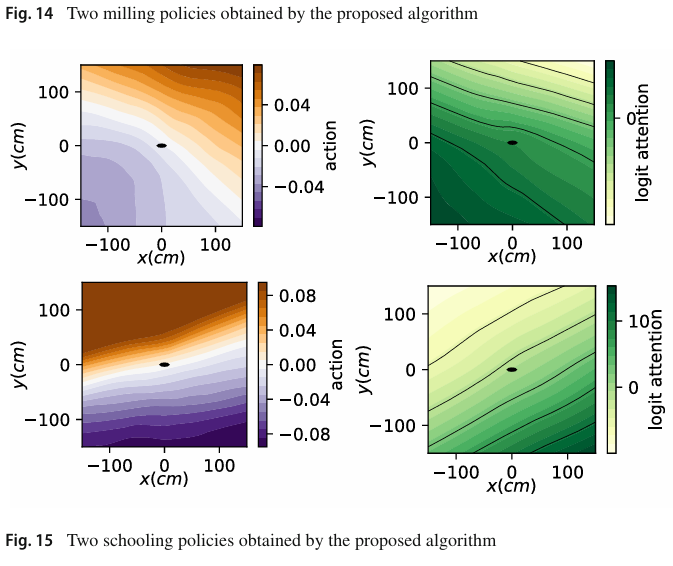

In [ ]:
model_folder = rf"..\models\trained_policies"
gail_pred_policy = torch.load(os.path.join(model_folder, "bc_pred_policy.pt"), weights_only=False)
gail_prey_policy = torch.load(os.path.join(model_folder, "bc_prey_policy.pt"), weights_only=False)

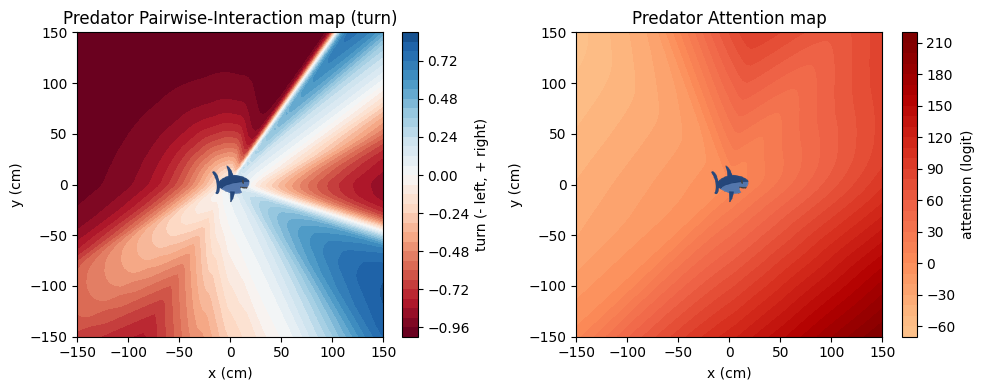

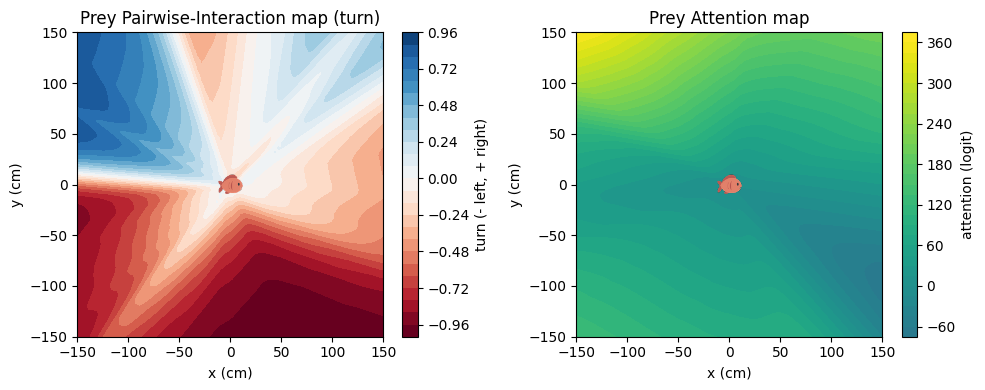

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------------------------------
# Pairwise-Action & Attention Maps
# -------------------------------------------------
def compute_pairwise_and_attention_maps(pairwise_net,
                                        attn_net,
                                        role,                 # "predator" oder "prey"
                                        v=1.0,
                                        x_range=(-150, 150),
                                        y_range=(-150, 150),
                                        n_points=80,
                                        n_orient=72,
                                        device="cpu"):

    pairwise_net.to(device).eval()
    attn_net.to(device).eval()

    xs = np.linspace(*x_range, n_points)
    ys = np.linspace(*y_range, n_points)

    thetas = torch.linspace(0.0, 2*np.pi, n_orient + 1, device=device)[:-1]
    vx = v * torch.cos(thetas)
    vy = v * torch.sin(thetas)

    action_map = np.zeros((n_points, n_points), dtype=np.float32)
    attn_map   = np.zeros((n_points, n_points), dtype=np.float32)

    with torch.no_grad():
        for ix, x in enumerate(xs):
            for iy, y in enumerate(ys):
                if abs(x) < 1e-6 and abs(y) < 1e-6:
                    action_map[iy, ix] = np.nan
                    attn_map[iy, ix] = np.nan
                    continue

                rel_x = torch.full((n_orient, 1), float(x), device=device)
                rel_y = torch.full((n_orient, 1), float(y), device=device)
                inputs = torch.cat([rel_x, rel_y, vx.unsqueeze(1), vy.unsqueeze(1)], dim=1)

                # ---- PairwiseInteraction -> Aktion ----
                mu, sigma = pairwise_net(inputs)
                turn = torch.tanh(mu.squeeze())   # [-1, 1]
                action_map[iy, ix] = turn.mean().item()

                # ---- Attention -> Gewicht (Logits) ----
                w_logits = attn_net(states=inputs, pred_states=inputs, role=role)

                # Falls das Netz ein Tuple (z.B. (w_prey, w_pred)) zurückgibt:
                if isinstance(w_logits, tuple):
                    w_logits = w_logits[0]   # ersten Output nehmen (typischerweise w_prey)

                w_logits = w_logits.squeeze()
                attn_map[iy, ix] = w_logits.mean().item()

    return xs, ys, action_map, attn_map


# -------------------------------------------------
# Plot
# -------------------------------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_policy_maps(xs, ys, action_map, attn_map, title_prefix="", img_path=None):

    # Turn-Map: immer diverging (links/rechts)
    cmap_action = "RdBu"
    # Attention: Predator rötlicher, Prey wie gehabt
    cmap_attn = "OrRd" if title_prefix.lower() == "predator" else "viridis"

    X, Y = np.meshgrid(xs, ys)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ---------- Pairwise Interaction (turn) ----------
    vmax_act = np.nanmax(np.abs(action_map))
    norm_act = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_act, vmax=vmax_act)

    im0 = axes[0].contourf(X, Y, action_map,
                           levels=30,
                           cmap=cmap_action,
                           norm=norm_act)
    axes[0].set_title(f"{title_prefix} Pairwise-Interaction map (turn)")
    axes[0].set_xlabel("x (cm)")
    axes[0].set_ylabel("y (cm)")
    plt.colorbar(im0, ax=axes[0], label="turn (- left, + right)")

    # ---------- Attention Map (logits, 0 zentriert) ----------
    vmax_att = np.nanmax(np.abs(attn_map))
    norm_att = colors.TwoSlopeNorm(vcenter=0, vmin=-vmax_att, vmax=vmax_att)

    im1 = axes[1].contourf(X, Y, attn_map,
                           levels=30,
                           cmap=cmap_attn,
                           norm=norm_att)
    axes[1].set_title(f"{title_prefix} Attention map")
    axes[1].set_xlabel("x (cm)")
    axes[1].set_ylabel("y (cm)")
    plt.colorbar(im1, ax=axes[1], label="attention (logit)")

    # ---------- Achsenbereich fixieren (+/- Maximalwert aus xs/ys) ----------
    x_range = (xs.min(), xs.max())
    y_range = (ys.min(), ys.max())

    for ax in axes:
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

    # ---------- Icon in der Mitte ----------
    if img_path is not None:
        icon = mpimg.imread(img_path)
        imgbox = OffsetImage(icon, zoom=0.45)
        center = (0, 0)
        for ax in axes:
            ab = AnnotationBbox(imgbox, center, frameon=False, xycoords='data')
            ax.add_artist(ab)

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# Anwendung auf deine Policies
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
pred_img_path = rf"..\data\predator.png"
prey_img_path = rf"..\data\prey.png"

# Predator
xs, ys, pred_action_map, pred_attn_map = compute_pairwise_and_attention_maps(
    pairwise_net=gail_pred_policy.pairwise,
    attn_net=gail_pred_policy.attention,
    role="predator",
    v=1.0,
    x_range=(-150, 150),
    y_range=(-150, 150),
    n_points=80,
    n_orient=72,
    device=device,
)
plot_policy_maps(xs, ys, pred_action_map, pred_attn_map, title_prefix="Predator", img_path=pred_img_path)

# Prey
xs, ys, prey_action_map, prey_attn_map = compute_pairwise_and_attention_maps(
    pairwise_net=gail_prey_policy.pairwise,
    attn_net=gail_prey_policy.attention,
    role="prey",
    v=1.0,
    x_range=(-150, 150),
    y_range=(-150, 150),
    n_points=80,
    n_orient=72,
    device=device,
)

plot_policy_maps(xs, ys, prey_action_map, prey_attn_map, title_prefix="Prey", img_path=prey_img_path)
